<a href="https://colab.research.google.com/github/evgeny-kolonsky/DCmanual/blob/main/Lab4_Balmer_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab4 - Hydrogen visible spectrum. Solution

Set #1 measured

v.0.1.2

# Prism measurements

In [1]:
! pip install uncertainties

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.umath import sin, cos, atan, sqrt
from uncertainties import unumpy as unp

from scipy.constants import hbar, h, c, Rydberg, electron_mass as me, elementary_charge as e, epsilon_0



# Auxillary functions

## Automatic color assignment

for better colors drawing

In [3]:
def wavelength_to_color(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''
    wavelength = float(wavelength)
    if wavelength < 380:
        wavelength = 380.
    if wavelength > 750:
        wavelength = 750.
    if 380 <= wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif 440 <= wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif 490 <= wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif 510 <= wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif 580 <= wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif 645 <= wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    r = int(R*255)
    g = int(G*255)
    b = int(B*255)
    return "#{:02x}{:02x}{:02x}".format(r, g, b)

## Weighted average

In [4]:
# weighted average
def umean(ux: unp.uarray) -> ufloat:
  values = unp.nominal_values(ux)
  uncertainties = unp.std_devs(ux)
  if np.prod(uncertainties) == 0: # algorythm fails when at  sigma=0
    res =  ufloat( np.mean(values), np.mean(uncertainties))
  else:
    weights = 1 / uncertainties**2
    weighted_average = sum(values * weights) / sum(weights)
    weighted_error = 1 / np.sqrt(sum(weights))
    res = ufloat(weighted_average, weighted_error)
  return res

RESOLUTION = 360 / 8000 # deg
beta_err = 2* RESOLUTION * np.pi / 180 # rad


## Hydrogen nominal values

In [5]:
lines = ['0 Violet 410', '1 Blue 434', '2 Tourqise 486', '3 Red 656']
nominal_waves = [410.2, 434.0, 486.1, 656.3]
python_colors = [wavelength_to_color(wl) for wl in nominal_waves]
qnumbers = [6, 5, 4, 3]


# Prism measurements

Set #1

## Model
$$
n(\theta) = 2 \sin\left(30^\circ + \frac{\theta}{2}\right)
\tag{1}
$$

$$
n(\lambda) = A  + \frac{B}{\lambda^2}
\tag{2}
$$



Fitting aproach:
1. For known helium  measurements $(\lambda, \theta)$ calculate $n(\theta)$  with eq(1).
2. Suggest that $x = \frac{1}{\lambda^2}$ and $ y = n$ and fit eq(2) to find $A$ and $B$ constants with their errors.
3. Measure angles $\theta$ for hydrogen. Calculate $n(\theta)$ with eq(1).
4. Find wavelengths of hydrogen  for fitted $A,B$ constants with eq(3):
$$
\frac{1}{\lambda^2} = \frac{n - A}{B}
\tag{3}
$$
5. Esitmate errors for $\lambda$ as propagated errors from fit parameters $A$ and $B$.


## Calibrate - get material parameters $A$ and $B$ on known Helium lines, test on Mercury green line

A = 1.5932+/-0.0004, B = (9.02+/-0.10)e+03 1/nm2


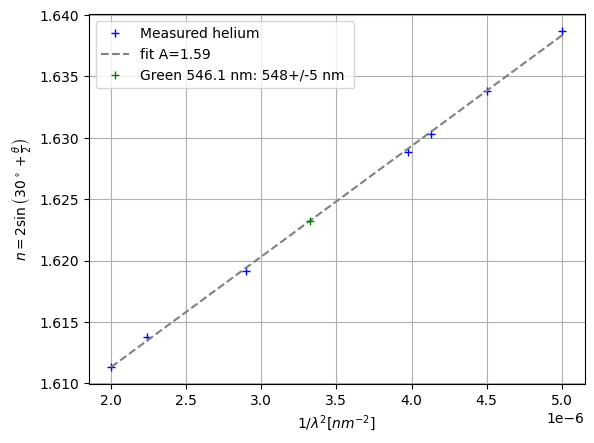

In [14]:
# calibrate
data = '''
# wavelength theta
# helium
447.15 50.040
471.31 49.556
492.19 49.207
501.5 49.061
587.56 48.105
667.82 47.587
706.52 47.351
'''
lmd, theta = np.genfromtxt(data.splitlines()).T
theta *= np.pi/ 180
x = 1 / lmd**2
n = 2 * np.sin(np.pi/6 + theta/2)

plt.style.use('default')

plt.plot(x, n, '+', color='blue', label='Measured helium')
fit = linregress(x, n)
A, B = fit.intercept, fit.slope
A_err, B_err = fit.intercept_stderr, fit.stderr
uA = ufloat(A, A_err)
uB = ufloat(B, B_err)
print(f'A = {uA}, B = {uB} 1/nm2')
plt.plot(x, A + B * x, '--', color='gray', label=f'fit {A=:.2f}')

# test on Mercury green line

mercury = '''
# wavelength theta
# mercury
546.1 48.510 0.011
'''
wl, theta, err = np.genfromtxt(mercury.splitlines()).T


utheta = np.pi/ 180 * ufloat(theta, err)
un = 2 * unp.sin(np.pi/6 + utheta/2)
ux = (un - uA) / uB
green_test = 1 / unp.sqrt(ux)
plt.plot(ux.n, un.n, '+', color='green', label=fr'Green {wl} nm: {green_test} nm ')

plt.ylabel(r'$n = 2 \sin\left(30^\circ + \frac{\theta}{2}\right)$')
plt.xlabel('1/$\\lambda^2 [{nm}^{-2}]$')
plt.legend()
plt.grid()



## Measure Hydrogen lines using calibrated prism

In [17]:
hydrogen = '''
6 410.2 51.007
5 434.0 50.366
4 486.1 49.331
3 656.3 47.655
'''
qnumber, nominal, theta = np.genfromtxt(hydrogen.splitlines()).T
theta *= np.pi/ 180
n = 2 * np.sin(np.pi/6 + theta/2)

x = (n - uA) / uB
xvalues = [x_.n for x_ in x]
xerrors = [x_.s for x_ in x]

lambda_h = 1/ unp.sqrt(x) *1e-9

for i, l in enumerate(lambda_h):
    print(f'Quantum number {qnumber[i]:.0f}; Nominal wl {nominal[i]} nm; Measured wl: {l*1e9} nm')





Quantum number 6; Nominal wl 410.2 nm; Measured wl: 404.7+/-2.6 nm
Quantum number 5; Nominal wl 434.0 nm; Measured wl: 430.3+/-2.8 nm
Quantum number 4; Nominal wl 486.1 nm; Measured wl: 485.1+/-3.5 nm
Quantum number 3; Nominal wl 656.3 nm; Measured wl: 652+/-7 nm


## Rydberg's constant

$$
    R_{\infty} = \frac{1}{(4 \pi \varepsilon_0)^2} \frac{m_e e^4}{4 \pi c \hbar^3}.
$$

In [23]:
#values = np.array([R_.n for R_ in R])
#errors = np.array([R_.s for R_ in R])
#R_mean, R_err = weighted_average(values, errors)

R = 1 / lambda_h / (1/4 - 1/qnumber**2)

uR = umean(R)
print(f'Measured Rydberg constant:   {uR:.0f} 1/m')

R_infty = me * e**4  / (4 * np.pi * epsilon_0) **2 / (4* np.pi * c * hbar**3)
print(f'Calculated Rydberg constant: {R_infty:.0f} 1/m')
print(f'Relative precision (error / value): {uR.s / uR.n*100:.2f} %')
print(f'Relative accuracy (value / theoretical_value - 1): {(uR.n/R_infty -1)*100:.2f} %')

Measured Rydberg constant:   11062629+/-39599 1/m
Calculated Rydberg constant: 10973732 1/m
Relative precision (error / value): 0.36 %
Relative accuracy (value / theoretical_value - 1): 0.81 %


# Diffraction grating measurements

Theoretical expression for light diffraction when incident light is assumed to be perpendicular to grating  is
$$    
n \lambda = d \sin \beta_n,
    \tag{1}    
$$
where $\lambda$ - light wave length, $d$ - diffraction grating parameter, $n$ - diffraction order number, $\beta_n$ - diffraction angle incident light and diffracted light of order $n$.

When incident light falls under an arbitrary angle $\alpha_0$ relative to the grating plane perpendicular, the expression is written in form \cite{PhysLabManual-1972}
$$
n \lambda = 2 d \sin \frac{\beta_n}{2} \cos\left(i_0 +
\frac{\beta_n}{2} \right) , \quad n =  \pm 1, \pm 2, ..
\tag{2}   
$$

For $i_0=0$ (light falls perpendicularly) we receive eq.(1).  


The unknown angle $\alpha_0$ between grating plane perpendicular and light beam can be found directly by measuring $\beta_{\pm n}$ of symmetric orders $\pm n$, even when  grating period $d$ and wavelength $\lambda$ are  unknown. Denoting for simplicity $\beta_+$ and $\beta_-$ diffraction angles for an arbitrary orders $\pm n$ in eq.(2), we have  
$$
\sin \frac{\beta_{+}}{2} \cos\left( i_0 + \frac{\beta_{+}}{2}\right) + \sin \frac{\beta_{-}}{2} \cos\left( i_0 + \frac{\beta_{-}}{2}\right) =0.
\tag{3}
$$
This is an equation with one unknown parameter $\alpha_0$. The solution is:
$$
i_0 = \arctan\frac{\sin\beta_+ + \sin\beta_- }{2 - \cos\beta_+ -
\cos\beta_-}.
\tag{4}
$$



In [8]:
def get_i0(beta_plus, beta_minus):
  s1 = sin(beta_plus)
  s2 = sin(beta_minus)
  c1 = cos(beta_plus)
  c2 = cos(beta_minus)
  tan_alpha =  (s1 + s2) / (2 - c1 - c2)
  alpha0 = atan(tan_alpha)
  return alpha0

def get_ui0(n, colors, beta):
  betas = {}
  for ix, b in enumerate(beta):
      betas[(int(color_index[ix]), int(n[ix]))] = b

  alphas = {}
  for key in betas:
    c = key[0]
    order = key[1]
    if (c, order) in betas and (c, -order) in betas:
      bp = betas[(c, order)]
      bm = betas[(c, -order)]
      ubp = ufloat(bp, beta_err)
      ubm = ufloat(bm, beta_err)
      alphas[key] = get_i0(ubp, ubm)
  al_arr = np.array(list(alphas.values()))
  return umean(al_arr)

## Calculate $i_0$

In [25]:
d = 1e-3 / 300 # 300 lines per mm

hydrogen = '''
# order color beta
+1 1  7.492
-1 1 -7.492
+1 2  8.381
-1 2 -8.392
+1 3  11.351
-1 3 -11.362
+2 2  16.931
-2 2 -16.998
+2 3  23.152
-2 3 -23.264
+3 2 25.920
-3 2 -26.054
+3 3 36.092
#-3 3 -36.993 outlier
'''

order, color_index, beta = np.genfromtxt(hydrogen.splitlines()).T
beta *= np.pi / 180

i0 = get_ui0(order, color_index, beta)
print(f'i0: {i0*180 / np.pi} degree')


i0: -0.61+/-0.30 degree


In [26]:
Ry = []
for ix in range(len(lines)):
  mask = color_index == ix
  b = beta[mask]
  n_ix =  order[mask]
  if len(beta[mask]) == 0:
    continue

  lmbd = np.array([2 * d *  sin(b[i] / 2) * cos(i0 + b[i] / 2) /n_ix[i] for i in range(len(b))])
  lmbd_mean = umean(lmbd)
  lmbd_n = len(lmbd)
  R = 1 / lmbd_mean / (1/4 - 1/qnumbers[ix]**2)
  Ry.append(R)
  print(rf'{lines[ix]:<15}: nominal {nominal_waves[ix]} lambda = {lmbd_mean*1e9} nm, {lmbd_n:d} points' )


1 Blue 434     : nominal 434.0 lambda = 434.70+/-0.10 nm, 2 points
2 Tourqise 486 : nominal 486.1 lambda = 486.22+/-0.11 nm, 6 points
3 Red 656      : nominal 656.3 lambda = 656.49+/-0.21 nm, 5 points


In [27]:
Ry_mean = umean(Ry)
print(f'Measured Ry                  {Ry_mean:.0f} 1/m')
print(f'Calculated Rydberg constant: {R_infty:.0f} 1/m')
print(f'Relative precision (error / value): {Ry_mean.s / Ry_mean.n*100:.2f} %')
print(f'Relative accuracy (value / theoretical_value - 1): {(Ry_mean.n/R_infty -1)*100:.2f} %')

Measured Ry                  10963014+/-1572 1/m
Calculated Rydberg constant: 10973732 1/m
Relative precision (error / value): 0.01 %
Relative accuracy (value / theoretical_value - 1): -0.10 %


1 Blue 434     : nominal 434.0 lambda = 434.70+/-0.10 nm, 2 points
2 Tourqise 486 : nominal 486.1 lambda = 486.22+/-0.11 nm, 6 points
3 Red 656      : nominal 656.3 lambda = 656.49+/-0.21 nm, 5 points


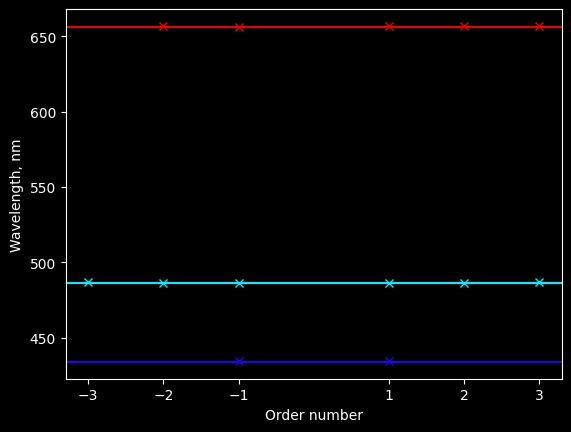

In [28]:
plt.style.use('dark_background')

for ix in range(1, len(lines)):
  b = beta[color_index == ix]
  n_ix =  order[color_index == ix]
  lmbd = np.array([2 * d *  sin(b[i] / 2) * cos(i0 + b[i] / 2) /n_ix[i] for i in range(len(b))])
  lmbd_mean = umean(lmbd)
  lmbd_n = len(lmbd)
  print(rf'{lines[ix]:<15}: nominal {nominal_waves[ix]} lambda = {lmbd_mean*1e9} nm, {lmbd_n:d} points' )


  plt.plot(n_ix, unp.nominal_values(lmbd) *1e9, 'x', color=python_colors[ix])
  plt.axhline(nominal_waves[ix], color=python_colors[ix])
  plt.xticks([int(nx) for nx in np.unique(order)])
  plt.xlabel('Order number')
  plt.ylabel(r'Wavelength, nm')
  #plt.legend()
